In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

from PIL import Image
from glob import glob

from torch import nn
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary

from skimage.exposure import histogram
from skimage.color import rgb2gray

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from skimage.feature import hog
from skimage import exposure
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
# Path to Dataset
root_path = '/content/drive/MyDrive/Intel Training Dataset/'

# split into subfolders based on class label
subfolders = sorted(glob(root_path + '*'))
label_names = [p.split('/')[-1] for p in subfolders]

print(label_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
start_time = time.time()
resnet50 = models.resnet50(pretrained=True)

#Drop last layer of the network
def slice_model(original_model, from_layer=None, to_layer=None):
  return nn.Sequential(*list(original_model.children()))[from_layer:to_layer]

model_conv_features = slice_model(resnet50, to_layer=-1).to('cpu')
summary(model_conv_features, input_size=(3,224,224))

In [ ]:
# preprocess
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def retype_image(in_img):
  if np.max(in_img) > 1:
    in_img = in_img.astype(np.uint8)
  else:
    in_img = (in_img * 255.0).astype(np.uint8)
  return in_img

duration = (time.time()-start_time) /60
print(f"It took {duration: .2f} seconds to set up the ResNet50")

It took  0.04 seconds to set up the ResNet50


In [ ]:
resnet50.eval()

In [ ]:
start_time = time.time()
num_per_class = 50

features = []
labels = []

for i in range(len(subfolders)):
  fnames = sorted(glob(subfolders[i]+ '/*.jpg'))

  for j in range(num_per_class):
    img = plt.imread(fnames[j])
    proc_img = preprocess(Image.fromarray(retype_image(img)))
    feat = model_conv_features(proc_img.unsqueeze(0).to('cpu')).squeeze().detach().numpy()
    # Add HOG features
    gray_img = rgb2gray(img)  # Convert the image to grayscale
    fd, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True)
    # Concatenate the HOG features to the existing deep learning features
    combined_features = np.concatenate((feat, fd))
    features.append(combined_features)
    labels.append(i)

features = np.array(features)
labels = np.array(labels)
print(features.shape)
# First num is img count and second is feature vector count
duration = (time.time()-start_time) / 60
print(f"It took {duration: .2f} minutes to extract the feature's from our data")

(300, 4640)
It took  3.46 minutes to extract the feature's from our data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=0
)

In [ ]:
clf = SVC()
clf.fit(X_train,y_train)
print({accuracy_score(y_test,clf.predict(X_test))})

{0.9333333333333333}


In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred) * 100
print(f"Train Accuracy: {accuracy: .3f}%")
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Test Accuracy: {accuracy: .3f}%")

Train Accuracy:  100.000%
Test Accuracy:  91.667%


In [ ]:
start_time = time.time()
grid = {'n_estimators': [139,140,141],
        }

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the training/test data
y_train_pred = best_rf_classifier.predict(X_train)
y_test_pred = best_rf_classifier.predict(X_test)

# Evaluate the performance on the training/test data
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
print(f"Training Accuracy: {train_accuracy: .2f}%")

test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Testing Accuracy: {test_accuracy: .2f}%")
duration = (time.time()-start_time) / 60
print(f"This grid_search took {duration: .2f} minutes")

Best Parameters: {'n_estimators': 140}
Training Accuracy:  100.00%
Testing Accuracy:  91.67%
This grid_search took  0.59 minutes


Testing Accuracy:  100.00%


<Axes: >

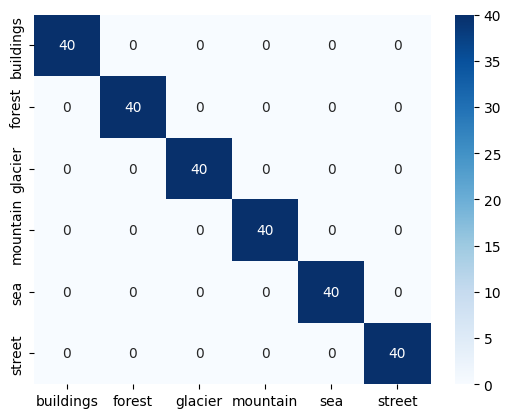

In [ ]:
class_names = [label_names[0],label_names[1],label_names[2],label_names[3],label_names[4],label_names[5]]
print(f"Testing Accuracy: {train_accuracy: .2f}%")
C = confusion_matrix(y_train, y_train_pred)
sn.heatmap(C, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

Testing Accuracy:  91.67%


<Axes: >

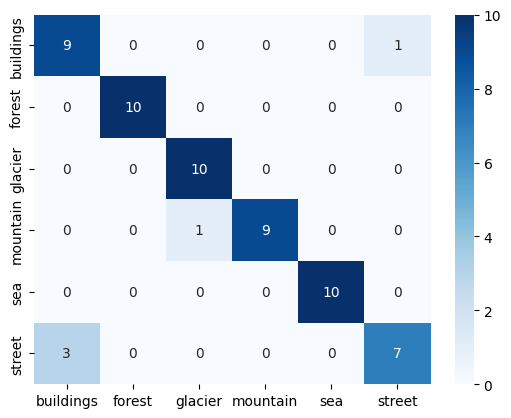

In [ ]:
print(f"Testing Accuracy: {test_accuracy: .2f}%")
C = confusion_matrix(y_test, y_test_pred)
sn.heatmap(C, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)